<a href="https://colab.research.google.com/github/benbatman/CNN_Projects/blob/main/tensorflow_GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf 
print(tf.__version__)

2.11.0


In [3]:
# Import dependencies 
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, \
BatchNormalization 
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import SGD, Adam 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import sys, os

In [11]:
# Load in the data
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data [-1, 1]
x_train, x_test = x_train / 255.0 * 2 -1, x_test / 255.0 * 2 -1
print("x_train shape:", x_train.shape)

x_train shape: (60000, 28, 28)


In [12]:
x_train[0].min(), x_train[0].max()

(-1.0, 1.0)

In [13]:
# Flatten the data (combinined H and W dims)
N, H, W = x_train.shape 
D = H*W 
x_train = x_train.reshape(-1,D)
x_test = x_test.reshape(-1, D)

print(N, H, W, D, x_train.shape, x_test.shape)

60000 28 28 784 (60000, 784) (10000, 784)


In [14]:
# Dimensionality of the latent space (hyperparameter)
latent_dim = 100 

In [15]:
# Build the generator model 
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(D, activation='tanh')(x)

  model = Model(i, x)
  return model 


In [16]:
# Build the discriminator model 
def build_discriminator(img_size):
  i = Input(shape=(img_size, ))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)
  model = Model(i, x)
  return model 

In [22]:
# Compile both models 
from tensorflow.keras.losses import BinaryCrossentropy 

discriminator = build_discriminator(D) 
discriminator.compile(loss=BinaryCrossentropy(), 
                      optimizer = Adam(learning_rate=0.0002, beta_1=0.5),
                      metrics=['accuracy'])

generator = build_generator(latent_dim)
generator.compile(loss=BinaryCrossentropy(),
                  optimizer=Adam(learning_rate=0.001),
                  metrics='accuracy')

# Create an input to represent noise samples from latent space 
z = Input(shape=(latent_dim,))

# Pass noise through generator to get an image 
img = generator(z)

# Make sure only the generator is trained 
discriminator.trainable = False 

# The true output is fake, but we label them real!
fake_pred = discriminator(img)

# Create the combined model object 
combined_model = Model(z, fake_pred)

# Compile the combined model 
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [23]:
# Train the GAN

# Config
BATCH_SIZE = 32
EPOCHS = 30000
SAMPLE_PERIOD = 200 # every 'sample_period' steps generate and save some data

# Create batch labels to use when calling train_on_batch 
ones = np.ones(BATCH_SIZE)
zeros = np.zeros(BATCH_SIZE)

# Initialize empty lists to store the losses
d_losses = []
g_losses = []

# Create a folder to store generated images 
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [24]:
# Function to generate a grid of random samples from the generator 
# and save them to a file
def sample_images(epoch):
  rows, cols = 5,5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)

  # Rescale images 0-1
  imgs = 0.5 * imgs + 0.5 

  fig, axs = plt.subplots(rows, cols)
  idx = 0 
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H,W), cmap='gray')
      axs[i,j].axis('off')
      idx += 1 
  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()

In [26]:
# Main training loop 
for epoch in range(EPOCHS):
  ### Train discriminator ###

  # Select a random batch of images
  idx = np.random.randint(0, x_train.shape[0], BATCH_SIZE)
  real_imgs = x_train[idx]

  # Generate fake images 
  noise = np.random.randn(BATCH_SIZE, latent_dim)
  fake_imgs = generator.predict(noise) # generator model is predictin on the noise

  # Train the discriminator
  # both loss and accuracy are returned 
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake) # average loss
  d_acc = 0.5 * (d_acc_real + d_acc_fake) # average acc

  ### Train generator ### 
  noise = np.random.randn(BATCH_SIZE, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)

  # Save the losses 
  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch+1}/{EPOCHS}, d_loss: {d_loss:.2f}, \
    d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")

  if epoch % SAMPLE_PERIOD == 0:
    sample_images(epoch)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 20ms/step
Epoch: 25101/30000, d_loss: 0.62,     d_acc: 0.67, g_loss: 0.94
1/1 [==============================] - 0s 18ms/step
Epoch: 25201/30000, d_loss: 0.68,     d_acc: 0.56, g_loss: 1.03
1/1 [==============================] - 0s 20ms/step
Epoch: 25301/30000, d_loss: 0.72,     d_acc: 0.53, g_loss: 1.08
1/1 [==============================] - 0s 19ms/step
Epoch: 25401/30000, d_loss: 0.68,     d_acc: 0.58, g_loss: 0.92
1/1 [==============================] - 0s 18ms/step
Epoch: 25501/30000, d_loss: 0.67,     d_acc: 0.66, g_loss: 1.01
1/1 [==============================] - 0s 23ms/step
Epoch: 25601/30000, d_loss: 0.61,     d_acc: 0.67, g_loss: 1.15
1/1 [==============================] - 0s 18ms/step
Epoch: 25701/30000, d_loss: 0.61,     d_acc: 0.66, g_loss: 1.05
1/1 [==============================] - 0s 18ms/step
Epoch: 25801/30000, d_loss: 0.70,     d_acc: 0.61, g_loss: 1.07
1/1 [================

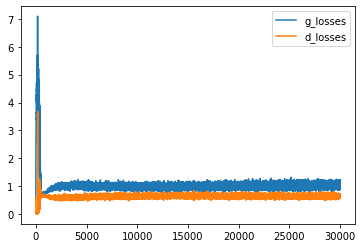

In [27]:
plt.plot(g_losses, label="g_losses")
plt.plot(d_losses, label='d_losses')
plt.legend()

In [28]:
!ls gan_images

0.png	   13800.png  17800.png  21600.png  25600.png  29600.png  6600.png
10000.png  14000.png  18000.png  21800.png  25800.png  29800.png  6800.png
1000.png   1400.png   1800.png	 22000.png  26000.png  3000.png   7000.png
10200.png  14200.png  18200.png  2200.png   2600.png   3200.png   7200.png
10400.png  14400.png  18400.png  22200.png  26200.png  3400.png   7400.png
10600.png  14600.png  18600.png  22400.png  26400.png  3600.png   7600.png
10800.png  14800.png  18800.png  22600.png  26600.png  3800.png   7800.png
11000.png  15000.png  19000.png  22800.png  26800.png  4000.png   8000.png
11200.png  15200.png  19200.png  23000.png  27000.png  400.png	  800.png
11400.png  15400.png  19400.png  23200.png  27200.png  4200.png   8200.png
11600.png  15600.png  19600.png  23400.png  27400.png  4400.png   8400.png
11800.png  15800.png  19800.png  23600.png  27600.png  4600.png   8600.png
12000.png  16000.png  20000.png  23800.png  27800.png  4800.png   8800.png
1200.png   1600.png   2000.png

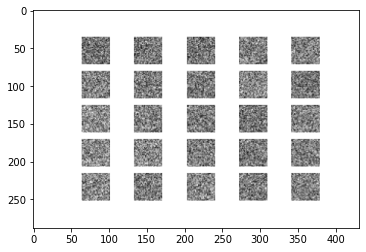

In [29]:
from skimage.io import imread 
a = imread('gan_images/0.png')
plt.imshow(a)

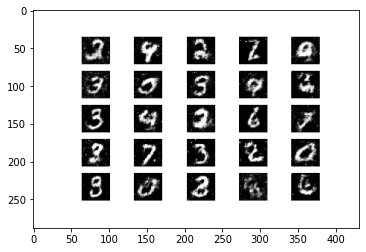

In [30]:
a = imread('gan_images/5000.png')
plt.imshow(a)

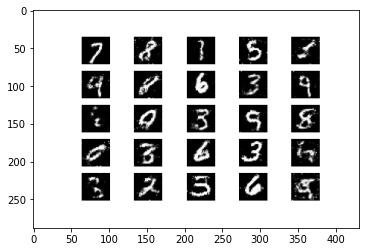

In [31]:
a = imread('gan_images/20000.png')
plt.imshow(a)

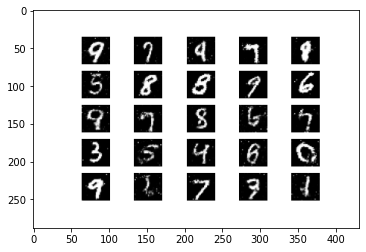

In [33]:
a = imread('gan_images/27000.png')
plt.imshow(a)